In [28]:
from scipy.io import loadmat
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_data = mnist_data / 255
mnist_label = mnist["label"][0]

In [30]:
train_ds_data, val_ds_data, train_ds_labels, val_ds_labels = train_test_split(mnist_data, mnist_label, test_size=0.10, random_state=42)

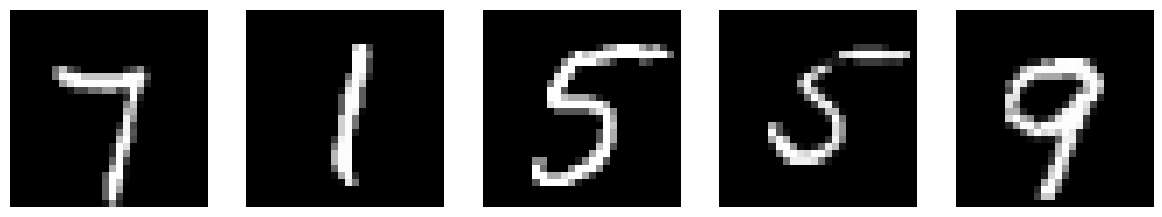

In [31]:
plt.figure(figsize=(30, 10))

for i in range(5):
    
    plt.subplot(1, 10, i+1)
    plt.imshow(train_ds_data[i].reshape(28, 28), cmap="gray")
    plt.axis('off')    
    
plt.show()

In [32]:
class nll:
    def compute_loss(self,predictions,y):
        self.predictions = predictions
        self.y = y
        batch_s = predictions.shape[1]
        self.loss = -np.log(predictions[y,np.arange(batch_s)])
        return self.loss
    def backward(self):
        grad = self.predictions.copy()
        grad[self.y, np.arange(self.predictions.shape[1])] -= 1
        return grad


criterion = nll()

In [33]:
class Sigmoid:
    def forward(self,x):
        self.x = x
        self.output =1/(1+np.exp(-x)) 
        return self.output
    def backward(self, grad_output):
        return grad_output * self.output * (1-self.output)


In [ ]:
def softmax(x):
    x = x - np.max(x, axis=0, keepdims=True)
    return (np.exp(x) / np.sum(np.exp(x),axis=0))

In [ ]:
class Layer:
    def __init__(self,input_size,activation_function=None,output_size=256, do_softmax = False):


        self.learning_rate = 0.01


        self.activation = Sigmoid() if activation_function == None else activation_function
        self.do_softmax = do_softmax
        self.input_size = input_size
        self.output_size = output_size


        self.weight =np.random.uniform(-1,1,size=(output_size,input_size))
        self.bias = np.zeros((output_size,1))
        
    def forward(self,x):
        if x.ndim == 1:
            x = x.reshape(-1,1)
        self.x_input = x
        self.bias_tilde = np.repeat(self.bias,x.shape[1],axis=1)

        self.z = np.dot(self.weight,x) + self.bias_tilde
        
        if self.do_softmax:
            self.a = softmax(self.z)
        else:
            self.a = self.activation.forward(self.z)
        return self.a
    def backward(self, grad_output):
        if self.do_softmax:
            delta = grad_output  
        else:
            delta = grad_output * self.activation.backward(self.z) 
        
        self.dw = np.dot(delta, self.x_input.T) / delta.shape[1]
        self.db = np.sum(delta, axis=1, keepdims=True) / delta.shape[1]
        
        grad_input = np.dot(self.weight.T, delta)
        return grad_input

    def step(self):

        self.weight -= self.learning_rate * self.dw
        self.bias -= self.learning_rate * self.db

In [36]:
a = Layer(input_size=train_ds_data[0].size, output_size=256)
b = Layer(input_size=a.output_size, output_size=256)
c = Layer(input_size=b.output_size, output_size=256)
d = Layer(input_size=c.output_size, output_size=10, do_softmax=True)

In [ ]:

for epoch in range(100):
    for i in range(0,train_ds_data.shape[0],64):

        batch = train_ds_data[i:i+64].T
        labels = train_ds_labels[i:i+64].astype(int)

        out_a = a.forward(batch)
        out_b = b.forward(out_a)
        out_c = c.forward(out_b)
        out_d = d.forward(out_c)


        loss = np.mean(criterion.compute_loss(out_d, labels))
        if i % 100 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}, Loss: {loss}")

        grad_d = criterion.backward()
        grad_c = d.backward(grad_d)
        grad_b = c.backward(grad_c)
        grad_a = b.backward(grad_b)
        _ = a.backward(grad_a) 

        d.step()
        c.step()
        b.step()
        a.step()


Epoch: 0, Iteration: 0, Loss: 9.0828695188765
Epoch: 0, Iteration: 1600, Loss: 5.843276744008526
Epoch: 0, Iteration: 3200, Loss: 3.7472749581367384
Epoch: 0, Iteration: 4800, Loss: 3.755543307369364
Epoch: 0, Iteration: 6400, Loss: 3.5563802311455754
Epoch: 0, Iteration: 8000, Loss: 3.6617487808028666
Epoch: 0, Iteration: 9600, Loss: 3.284971652869242
Epoch: 0, Iteration: 11200, Loss: 3.109856952053434
Epoch: 0, Iteration: 12800, Loss: 3.768606972773968
Epoch: 0, Iteration: 14400, Loss: 3.2219318601332536
Epoch: 0, Iteration: 16000, Loss: 2.957982613424659
Epoch: 0, Iteration: 17600, Loss: 3.1445069741706395
Epoch: 0, Iteration: 19200, Loss: 2.91986866855136
Epoch: 0, Iteration: 20800, Loss: 2.874442476789371
Epoch: 0, Iteration: 22400, Loss: 2.741685360571436
Epoch: 0, Iteration: 24000, Loss: 2.7103094115434674
Epoch: 0, Iteration: 25600, Loss: 3.1932821036513266
Epoch: 0, Iteration: 27200, Loss: 2.918993978375116
Epoch: 0, Iteration: 28800, Loss: 2.6458561447223232
Epoch: 0, Iterati

In [38]:
num_correct = 0
num_samples = 0
for i in range(0,val_ds_data.shape[0],64):
        batch = val_ds_data[i:i+64].T
        labels = val_ds_labels[i:i+64].astype(int)
        out_a = a.forward(batch)
        out_b = b.forward(out_a)
        out_c = c.forward(out_b)
        output = d.forward(out_c)
        output = np.argmax(output, axis= 0) 
        num_correct += (output == labels).sum()
        num_samples += batch.shape[1]


In [39]:
(num_correct/num_samples)*100

np.float64(79.04285714285714)